In [1]:
import numpy as np 
from scipy.signal import medfilt
# -- astropy -- 
import astropy.units as u
from astropy.table import Table as aTable
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

#### Read in Jeremy's exposures

In [3]:
exps = aTable.read(''.join([UT.dat_dir(), 'survey_exposures.fits']))

In [4]:
print('Columns = ', exps.colnames)
print('%i exposures' % len(exps))

('Columns = ', ['TILEID', 'PASS', 'RA', 'DEC', 'STATUS', 'COVERED', 'AVAILABLE', 'PLANNED', 'MJD', 'EXPTIME', 'SNR2FRAC', 'AIRMASS', 'SEEING', 'TRANSPARENCY', 'MOONFRAC', 'MOONALT', 'MOONSEP'])
4766 exposures


(0.0, 1.0)

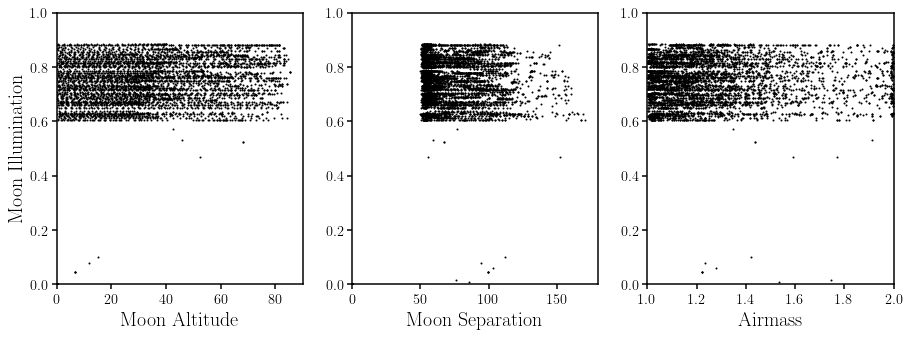

In [5]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(exps['MOONALT'], exps['MOONFRAC'], c='k', s=1)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0., 1.])
sub = fig.add_subplot(132)
sub.scatter(exps['MOONSEP'], exps['MOONFRAC'], c='k', s=1)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([0., 180.])
sub.set_ylim([0., 1.])
sub = fig.add_subplot(133)
sub.scatter(exps['AIRMASS'], exps['MOONFRAC'], c='k', s=1)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0., 1.])

In [6]:
specsim_sky = Sky.specsim_initialize('desi')
specsim_wave = specsim_sky._wavelength # Ang

/anaconda2/lib/python2.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [7]:
cr_def = specsim_sky.moon.KS_CR
cm0_def = specsim_sky.moon.KS_CM0
cm1_def = specsim_sky.moon.KS_CM1

def KS_sky(airmass, moonill, moonalt, moonsep): 
    # original KS sky
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    specsim_sky.moon.KS_CR = cr_def
    specsim_sky.moon.KS_CM0 = cm0_def
    specsim_sky.moon.KS_CM1 = cm1_def
    return specsim_sky.surface_brightness

In [8]:
def KSrescaled_sky(airmass, moonill, moonalt, moonsep): 
    # re-fit KS sky
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    specsim_sky.moon.KS_CR = 458173.535128
    specsim_sky.moon.KS_CM0 = 5.540103
    specsim_sky.moon.KS_CM1 = 178.141045
    return specsim_sky.surface_brightness

In [9]:
for i in range(len(exps)): 
    exps_ks_i = KS_sky(exps['AIRMASS'][i][0], exps['MOONFRAC'][i][0], exps['MOONALT'][i][0], exps['MOONSEP'][i][0])
    if i == 0: 
        exps_ks = np.zeros((len(exps), len(exps_ks_i)))
    exps_ks[i,:] = exps_ks_i.value

In [10]:
for i in range(len(exps)): 
    exps_new_i = KSrescaled_sky(exps['AIRMASS'][i][0], exps['MOONFRAC'][i][0], exps['MOONALT'][i][0], exps['MOONSEP'][i][0])
    if i == 0: 
        exps_new = np.zeros((len(exps), len(exps_ks_i)))
    exps_new[i,:] = exps_new_i.value

In [11]:
wlim_410 = ((specsim_wave.value > 3900) & (specsim_wave.value < 4100))
exps_ks_410 = np.zeros(len(exps))
exps_new_410 = np.zeros(len(exps))
for i in range(len(exps)): 
    exps_ks_410[i] = np.median(medfilt(exps_ks[i,wlim_410], 51))
    exps_new_410[i] = np.median(medfilt(exps_new[i,wlim_410], 51))

In [12]:
ratio_410 = exps_new_410/exps_ks_410

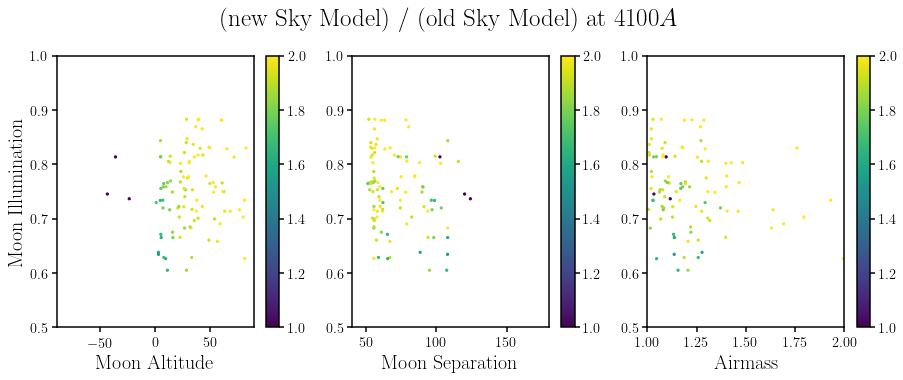

In [15]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
scat = sub.scatter(exps['MOONALT'][::50,0], exps['MOONFRAC'][::50,0], c=ratio_410[::50], s=5, vmin=1, vmax=2)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([-90., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(132)
scat = sub.scatter(exps['MOONSEP'][::50,0], exps['MOONFRAC'][::50,0], c=ratio_410[::50], s=5, vmin=1, vmax=2)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])
sub.set_title('(new Sky Model) / (old Sky Model) at $4100A$', pad=30, fontsize=25)
fig.colorbar(scat)

sub = fig.add_subplot(133)
scat = sub.scatter(exps['AIRMASS'][::50,0], exps['MOONFRAC'][::50,0], c=ratio_410[::50], s=5, vmin=1, vmax=2)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

In [65]:
wlim_460 = ((specsim_wave.value > 4400) & (specsim_wave.value < 4800))
exps_ks_460 = np.zeros(len(exps))
exps_new_460 = np.zeros(len(exps))
for i in range(len(exps)): 
    exps_ks_460[i] = np.median(medfilt(exps_ks[i,wlim_460], 51))
    exps_new_460[i] = np.median(medfilt(exps_new[i,wlim_460], 51))

In [67]:
ratio_460 = exps_new_460/exps_ks_460

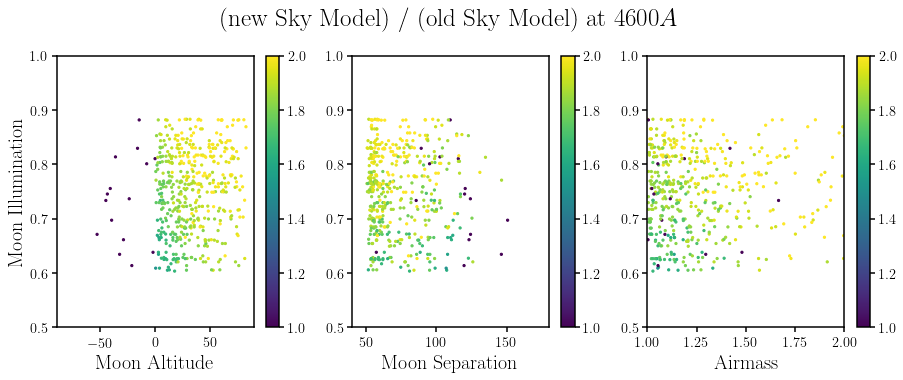

In [68]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
scat = sub.scatter(exps['MOONALT'][::10,0], exps['MOONFRAC'][::10,0], c=ratio_460[::10], s=5, vmin=1, vmax=2)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([-90., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(132)
scat = sub.scatter(exps['MOONSEP'][::10,0], exps['MOONFRAC'][::10,0], c=ratio_460[::10], s=5, vmin=1, vmax=2)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])
sub.set_title('(new Sky Model) / (old Sky Model) at $4600A$', pad=30, fontsize=25)
fig.colorbar(scat)

sub = fig.add_subplot(133)
scat = sub.scatter(exps['AIRMASS'][::10,0], exps['MOONFRAC'][::10,0], c=ratio_460[::10], s=5, vmin=1, vmax=2)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

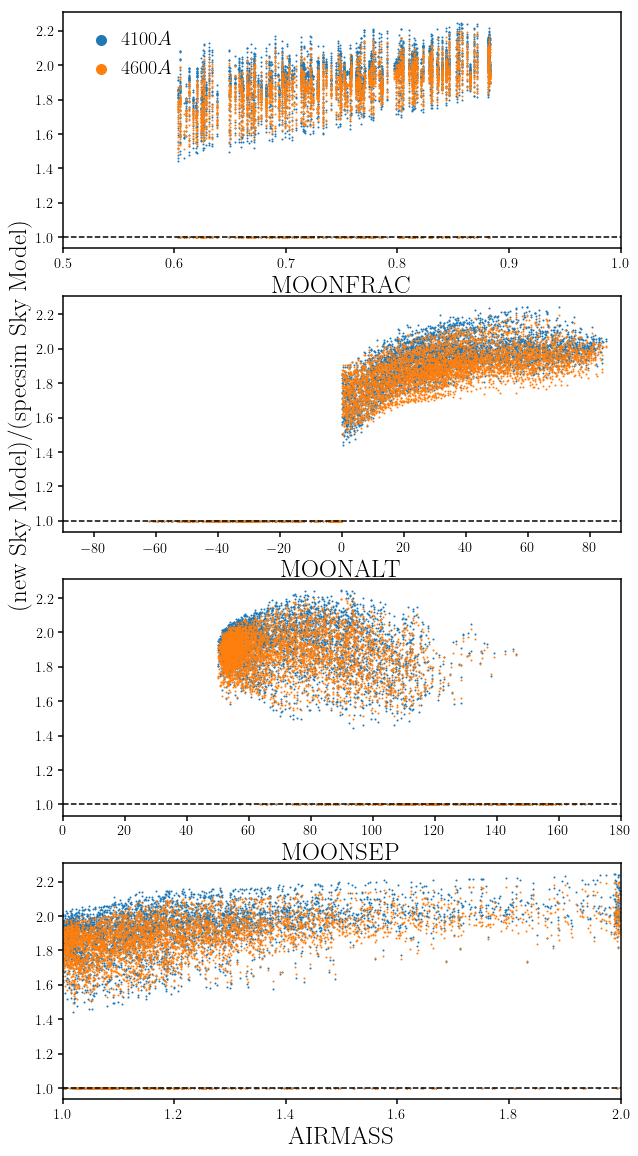

In [82]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOONFRAC', 'MOONALT', 'MOONSEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(exps[k][:,0], ratio_410, c='C0', s=1, label='$4100A$')
    sub.scatter(exps[k][:,0], ratio_460, c='C1', s=1, label='$4600A$')

    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper left', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.5, 1.])
    elif i == 1: 
        sub.set_xlim([-90., 90.])
        sub.set_ylabel('(new Sky Model)/(specsim Sky Model)', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])
    elif i == 4:
        sub.set_xlim([-90., 0.])
    sub.plot(sub.get_xlim(), [1., 1.], color='k', linestyle='--')